# Coupled Sensor Selection

This notebook aims to perform sensor selection on reprogrammed/reprogramming cells in the 2017 data set by utilizing infromation in the 2015 data set.

In [2]:
# Imports
import pandas as pd
import numpy as np
from copy import deepcopy
import os
import sys
from importlib import reload
from scipy.stats import zscore
import scipy.io
#from scipy.interpolate import make_interp_spline, BSpline
#from scipy.signal import savgol_filter as savgol 
#from sklearn.decomposition import PCA
#from sklearn.neighbors import NearestNeighbors
#import leidenalg
#import umap
#import time
import gget
#from sklearn import preprocessing
#from sklearn.preprocessing import StandardScaler
#from scipy.signal import savgol_filter
import scipy
import textwrap
from scipy import sparse
import importlib

#from pydmd import DMD

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

# local imports
sys.path.append("../python/")

import nb_util as nb
import utils as ut
reload(ut)

import hasnain_DMD
reload(hasnain_DMD)

import sensorSelection
reload(sensorSelection)

def getC(n, idxs):
    C = np.zeros((len(idxs), n))
    for i in range(len(idxs)):
        C[i, int(idxs[i])] = 1
    return C

def wrap_ylabels(ax, width):
    labels = []
    for label in ax.get_yticklabels():
        text = label.get_text()
        labels.append(textwrap.fill(text, width=width,
                      break_long_words=False))
    ax.set_yticklabels(labels, rotation=0)

## Load/Filter/Preprocess Data

In [3]:
# 2015 data
data_path_2015 = f"/nfs/turbo/umms-indikar/shared/projects/cell_cycle/data/RNA_pipeline_ouputs/countMatrix/counts.raw.txt"
gene_path_2015 = f"/nfs/turbo/umms-indikar/shared/projects/cell_cycle/data/RNA_pipeline_ouputs/references/geneTable.csv"

# 2018 data
data_path_2018 = f"/nfs/turbo/umms-indikar/shared/projects/myod/data/rnaseq/2018_rna/countMatrix/counts.raw.txt"
gene_path_2018 = f"/nfs/turbo/umms-indikar/shared/projects/myod/data/rnaseq/2018_rna/references/geneTable.csv"

# Load the raw expression
df_2015 = pd.read_csv(data_path_2015, index_col=0)
df_2018 = pd.read_csv(data_path_2018, index_col=0)

# remove MT and ribosomal genes
all_genes_2015 = df_2015.index.to_list()
all_genes_2018 = df_2018.index.to_list()
mt_genes_2015 = [x for x in all_genes_2015 if x.startswith('MT-')]
rp_genes_2015 = [x for x in all_genes_2015 if x.startswith('RP')]
mt_genes_2018 = [x for x in all_genes_2018 if x.startswith('MT-')]
rp_genes_2018 = [x for x in all_genes_2018 if x.startswith('RP')]
df_2015 = df_2015.drop(mt_genes_2015) # drop MT genes
df_2015 = df_2015.drop(rp_genes_2015) # drop ribosomal genes
df_2018 = df_2018.drop(mt_genes_2018) # drop MT genes
df_2018 = df_2018.drop(rp_genes_2018) # drop ribosomal genes

# rewrite the list for removed genes
gene_names_2015 = df_2015.index.to_list()
gene_names_2018 = df_2018.index.to_list()

# Load gene lengths
gf_2015 = nb.getGeneLengths(gene_path_2015, gene_names_2015)
gf_2018 = nb.getGeneLengths(gene_path_2018, gene_names_2018)

# Convert to TPM
tpm_2015 = nb.TPM(df_2015, gf_2015)
tpm_2018 = nb.TPM(df_2018, gf_2018)

print(tpm_2015.shape)
print(tpm_2018.shape)

/home/jpic/DMD_gene/notebooks/nb_util.py:113: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  gf = pd.read_csv(gene_table_path)
/home/jpic/DMD_gene/notebooks/nb_util.py:113: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  gf = pd.read_csv(gene_table_path)


(19235, 18)
(19235, 48)


In [4]:
# filter out uninteresting genes
def filterGeneSet(tpm_2015, tpm_2018, k=1000, criteria='entropy'):
    if criteria == 'entropy':
        tpm_2015_normalized = tpm_2015.div(tpm_2015.sum(axis=1), axis=0)
        tpm_2018_normalized = tpm_2018.div(tpm_2018.sum(axis=1), axis=0)
        tpm_score_2015 = -(tpm_2015_normalized * np.log(tpm_2015_normalized)).sum(axis=1)
        tpm_score_2018 = -(tpm_2018_normalized * np.log(tpm_2018_normalized)).sum(axis=1)
    elif criteria == 'avg. expression':
        tpm_score_2015 = tpm_2015.mean(axis=1)
        tpm_score_2018 = tpm_2018.mean(axis=1)
    elif criteria == 'std.':
        tpm_score_2015 = tpm_2015.std(axis=1)
        tpm_score_2018 = tpm_2018.std(axis=1)

    # select k largest indices
    top_k_indices_2015 = tpm_score_2015.nlargest(k).index
    top_k_indices_2018 = tpm_score_2018.nlargest(k).index

    # take union of genes selected from 2015 and 2018
    include_indices = (top_k_indices_2015).union(top_k_indices_2018)

    # remove genes not aparent in both 2015 and 2018
    common_indices = set(tpm_2015.index) & set(tpm_2018.index)
    include_indices = include_indices.intersection(common_indices)

    # recude the data to have the same indices
    tpm_r_2015 = tpm_2015[tpm_2015.index.isin(include_indices)]
    tpm_r_2018 = tpm_2018[tpm_2015.index.isin(include_indices)]

    # convert to DMD format
    dmd_data_2015 = nb.data2DMD(tpm_r_2015)
    dmd_data_2018 = nb.data2DMD2017(tpm_r_2018)
    gene_list = include_indices
    return dmd_data_2015, dmd_data_2018, gene_list

selectionCriteria = ['entropy', 'avg. expression', 'std.']
dmd_data_2015, dmd_data_2018, gene_list = filterGeneSet(tpm_2015, tpm_2018, k=1000, criteria=selectionCriteria[0])

print(dmd_data_2015.shape)
print(dmd_data_2018.shape)

(1770, 8, 2)
(1770, 15, 2)


/home/jpic/.local/lib/python3.9/site-packages/pandas/core/internals/blocks.py:329: RuntimeWarning: divide by zero encountered in log
  result = func(self.values, **kwargs)
/home/jpic/.local/lib/python3.9/site-packages/pandas/core/internals/blocks.py:329: RuntimeWarning: divide by zero encountered in log
  result = func(self.values, **kwargs)


## Comparative Sensor Selection

This section performs sensor selection on both data sets separately, and looks at the differences between what is expressed in each.

In [7]:
ss2015 = sensorSelection.hasnain2023(dmd_data_2015, dmd_rank=7, gramT=30, vxNames=gene_list)
ss2018 = sensorSelection.hasnain2023(dmd_data_2018, dmd_rank=7, gramT=30, vxNames=gene_list)

In [8]:
num_sensors = 100
ccSensors = ss2015['sensors']['gene'][0:num_sensors]
rpSensors = ss2018['sensors']['gene'][0:num_sensors]
ccSensors = set(list(ccSensors))
rpSensors = set(list(rpSensors))
diff = rpSensors.difference(ccSensors)
# diff = rpSensors[not rpSensors.isin(ccSensors)]
# set_difference = series1[~series1.isin(series2)]
# diff = rpSensors.difference(ccSensors)

print(len(diff))
print(len(ccSensors))
print(len(rpSensors))
print(ccSensors)

57
100
100
{'AAK1', 'ACBD6', 'TDRD3', 'PTPRM', 'ATRN', 'SPRED1', 'TXNDC12', 'HDGFL3', 'CUX1', 'ITFG1', 'GNAQ', 'FBXW8', 'XPR1', 'ARMH3', 'MAP3K20', 'ATP6V1H', 'TJP1', 'MSRA', 'TSPAN4', 'NFIC', 'UBE2E2', 'COX10', 'TYW1', 'SNRK', 'RAB34', 'PIAS2', 'PEPD', 'PPP1R13B', 'TLK2', 'NBAS', 'UBE2W', 'GALK2', 'RAB28', 'SLC39A11', 'RNGTT', 'EPN2', 'ADK', 'COG5', 'RAB11FIP5', 'MRPS22', 'LNX1', 'APP', 'STX18', 'LAYN', 'RGS12', 'SLC37A3', 'VTI1A', 'MCPH1', 'TIMP2', 'AEBP2', 'EXOC2', 'PARG', 'MID2', 'IMPACT', 'KIRREL1', 'CASK', 'RNF220', 'UBXN8', 'TEAD3', 'SEC22A', 'MMP2', 'TSPAN6', 'VPS13B', 'EVI5', 'PEX14', 'FSTL1', 'ITCH', 'CCNY', 'NQO2', 'CTBP2', 'PACRGL', 'DIS3L2', 'ANO10', 'ADCY6', 'A2M', 'IFT57', 'VWA8', 'CDC42BPB', 'ATG5', 'TUSC3', 'FGD1', 'FAM118B', 'AMMECR1', 'ANTXR1', 'FRMD4A', 'ATG4A', 'CHPT1', 'ERI3', 'ZFHX3', 'INTS12', 'SESTD1', 'NME7', 'CNRIP1', 'VPS13D', 'FTO', 'CDK8', 'AKT3', 'TCF12', 'EXT2', 'SPPL3'}


In [33]:
# diff.intersection(ccSensors)#) == len(diff)
diff

{'AGTPBP1',
 'ARHGDIB',
 'ATG10',
 'ATG7',
 'CABLES1',
 'CCDC12',
 'CCDC88C',
 'CLEC16A',
 'CNTRL',
 'CYB5R4',
 'DDX19B',
 'DOCK2',
 'DOCK8',
 'EHMT1',
 'GSE1',
 'HCLS1',
 'INTS4',
 'IRF4',
 'ITM2A',
 'KIF21A',
 'LAT2',
 'LCP1',
 'LSP1',
 'LY86',
 'MAIP1',
 'MCCC1',
 'MYB',
 'MZB1',
 'NARS2',
 'NT5DC1',
 'NVL',
 'PALS2',
 'PARN',
 'PAX5',
 'PHKA2',
 'PHKB',
 'PPCDC',
 'PREX1',
 'PRKCB',
 'PRPSAP2',
 'RNASEH2B',
 'SCMH1',
 'SDHA',
 'SGPP2',
 'SMIM12',
 'SNX14',
 'SP4',
 'SPAG1',
 'TBCA',
 'TFB1M',
 'TMEM14B',
 'TNFSF14',
 'VAMP8',
 'VOPP1',
 'WARS2',
 'WWP2',
 'ZNF589'}

In [34]:
db = 'GO_Biological_Process_2021'
edf = gget.enrichr(diff, database=db)

Fri Nov 17 14:46:07 2023 INFO Performing Enichr analysis using database GO_Biological_Process_2021.


In [35]:
print(edf)

     rank                                          path_name     p_val  \
0       1  regulation of T-helper cell differentiation (G...  0.000119   
1       2                        macroautophagy (GO:0016236)  0.000381   
2       3  regulation of protein modification process (GO...  0.000415   
3       4      lipoprotein biosynthetic process (GO:0042158)  0.000432   
4       5  C-terminal protein amino acid modification (GO...  0.000517   
..    ...                                                ...       ...   
503   504            nervous system development (GO:0007399)  0.724792   
504   505  positive regulation of cell population prolife...  0.745665   
505   506  negative regulation of apoptotic process (GO:0...  0.753716   
506   507               protein phosphorylation (GO:0006468)  0.761516   
507   508                protein ubiquitination (GO:0016567)  0.780936   

        z_score  combined_score            overlapping_genes  adj_p_val  \
0    181.263636     1638.233527     

ValueError: min() arg is an empty sequence

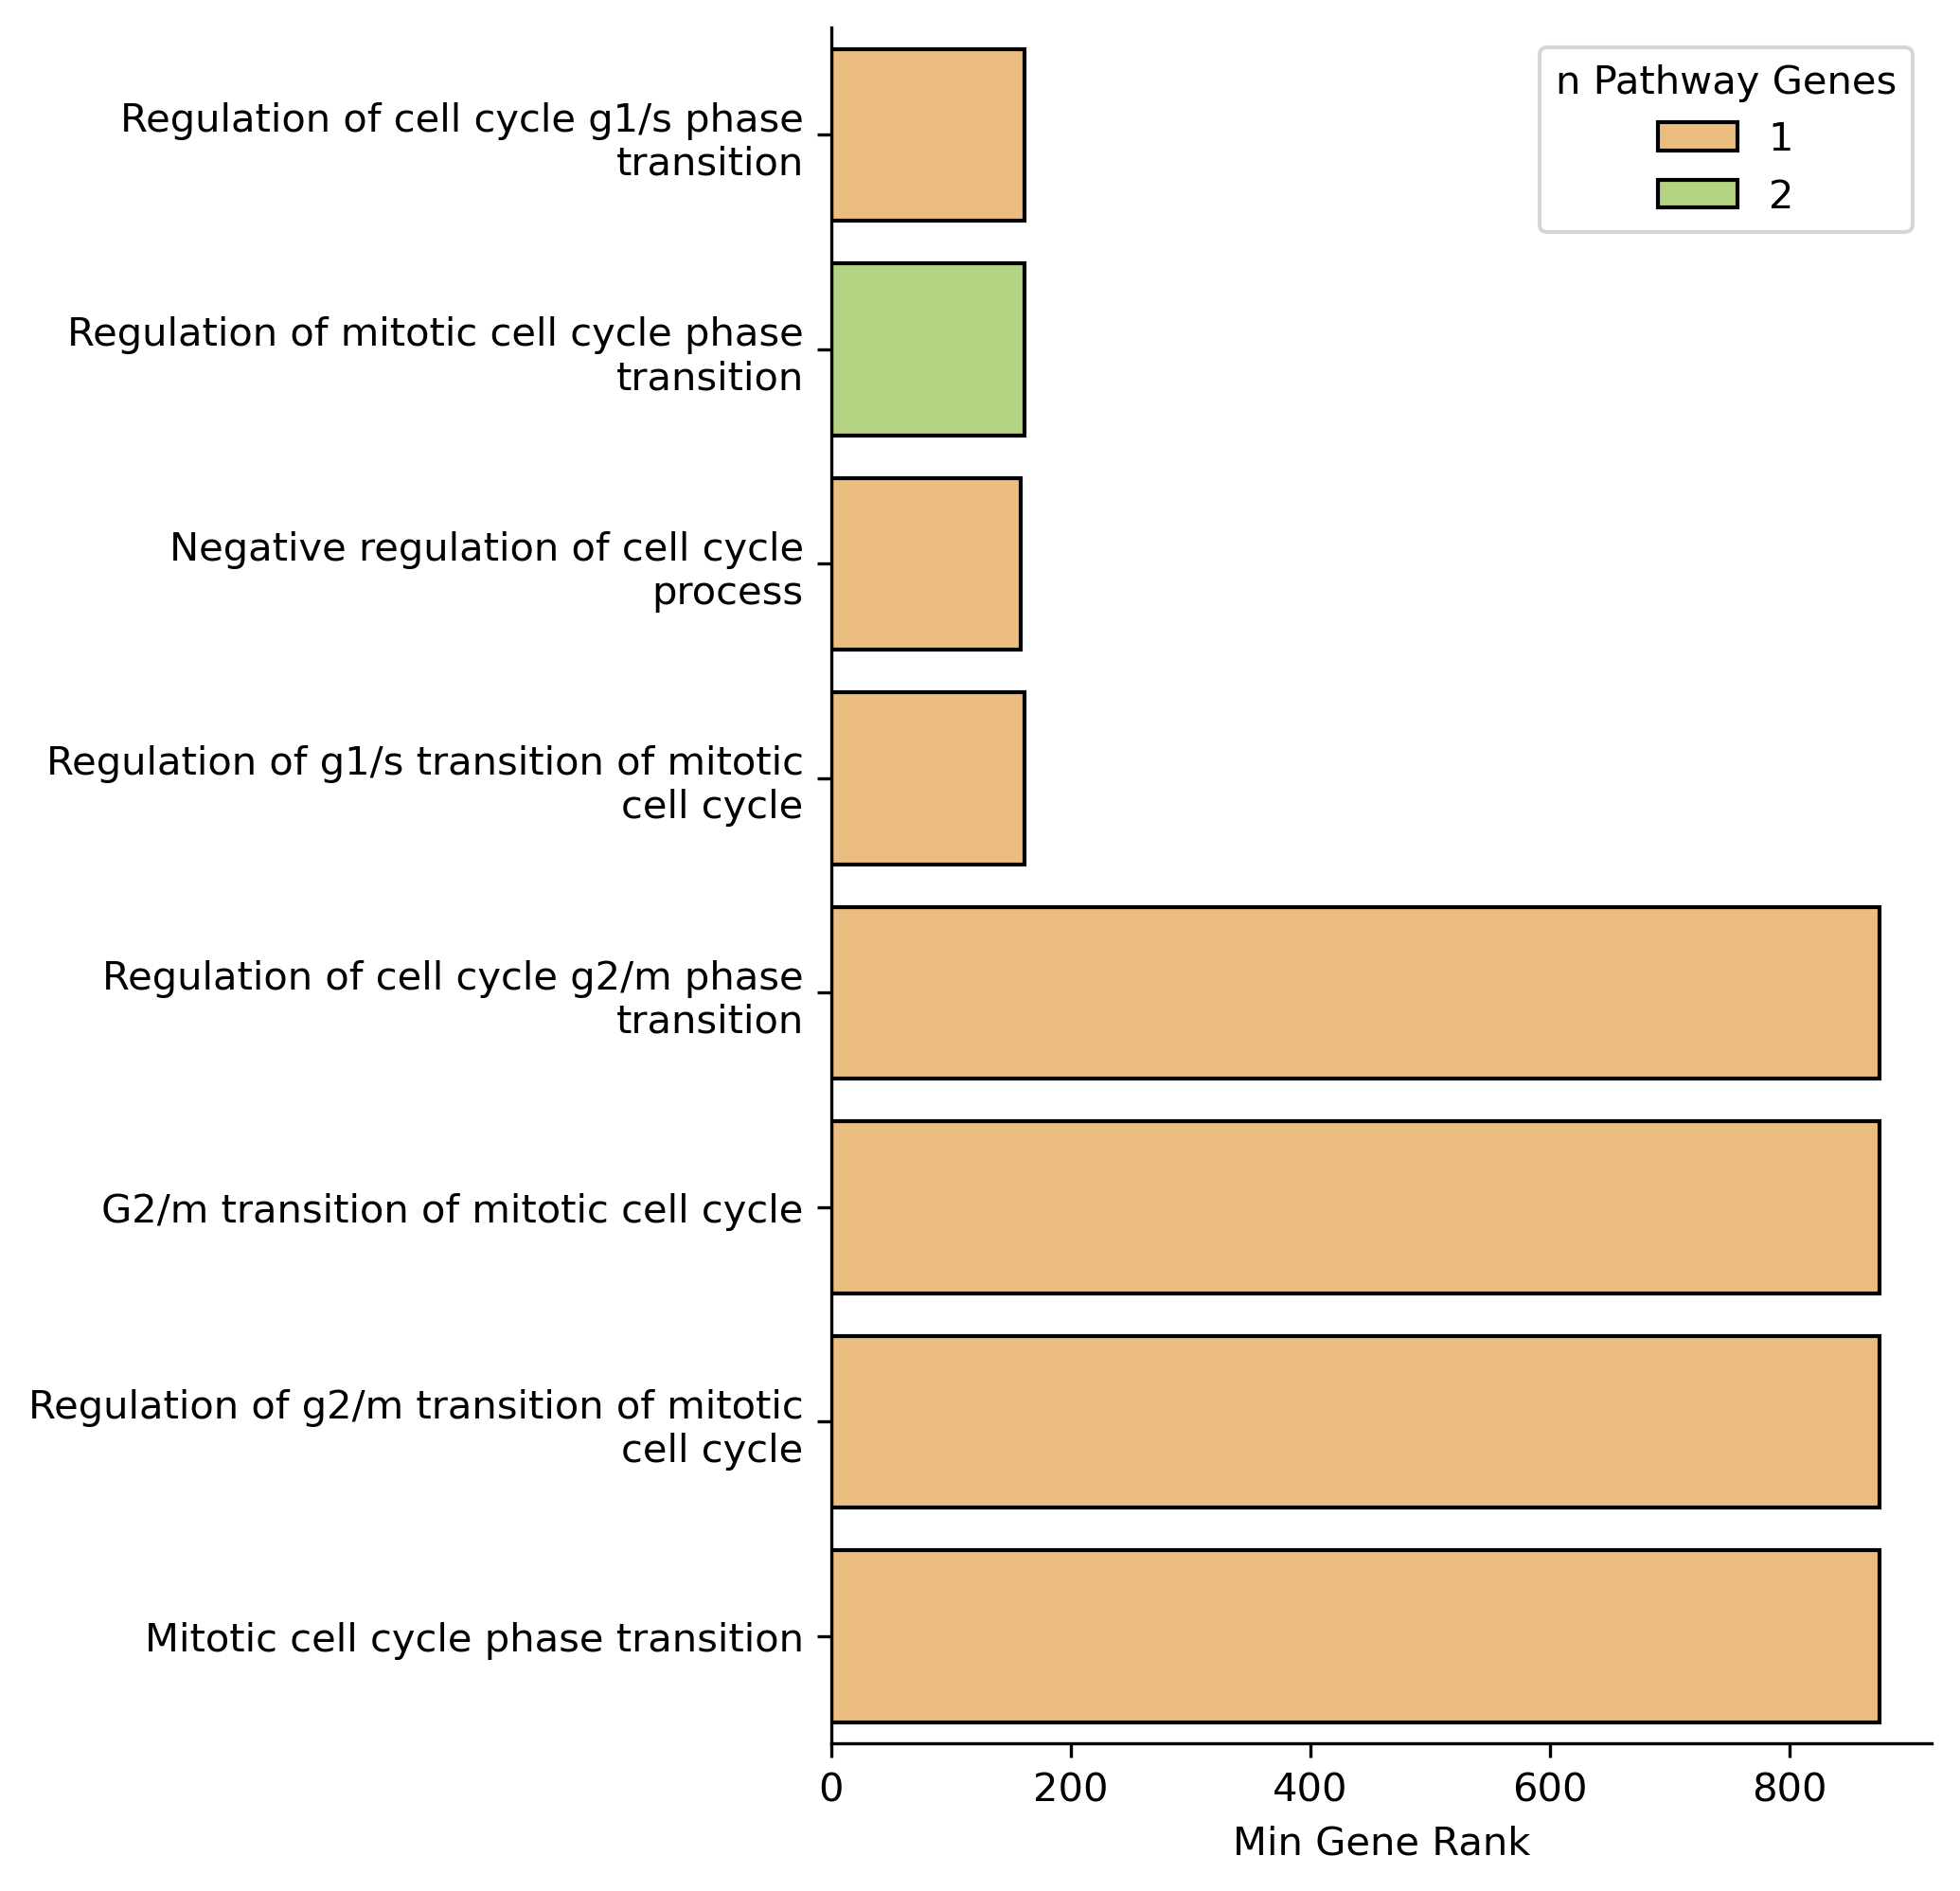

In [36]:
thresh = 0.01
alpha = 0.5

pdf = edf.copy()
pdf = pdf[pdf['adj_p_val'] <= alpha]

pdf['n_gene'] = pdf['overlapping_genes'].apply(lambda x: len(x))
pdf['logp'] = -1 * np.log10(pdf['adj_p_val'])
pdf['name'] = pdf['path_name'].apply(lambda x: x.split("(")[0].capitalize())
pdf['name_sig'] = pdf[['name', 'adj_p_val']].apply(lambda x: x[0].strip() + "*" if x[1] < thresh else x[0], axis=1)

# get the cell cycle processes
pdf['cell_cycle'] = pdf['name'].apply(lambda x: 1 if 'cell cycle' in x else 0)
pdf = pdf[pdf['cell_cycle'] == 1]

pdf['rank'] = pdf['overlapping_genes'].apply(lambda x: ss2015['sensors'][ss2015['sensors']['gene'].isin(x)]['rank'].min())

plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 5, 8

sns.barplot(data=pdf, 
            y='name_sig',
            x='rank',
            hue='n_gene',
            dodge=False,
            ec='k',
            palette='RdYlGn')

plt.ylabel("")
plt.xlabel("Min Gene Rank")
wrap_ylabels(plt.gca(), width=40)
sns.despine()
sns.move_legend(plt.gca(), 
                loc='upper right',
                title='n Pathway Genes')
pdf.head()
thresh = 0.01
alpha = 0.05

pdf = edf.copy()
pdf = pdf[pdf['adj_p_val'] <= alpha]

pdf['n_gene'] = pdf['overlapping_genes'].apply(lambda x: len(x))
pdf['logp'] = -1 * np.log10(pdf['adj_p_val'])
pdf['name'] = pdf['path_name'].apply(lambda x: x.split("(")[0].capitalize())
pdf['name_sig'] = pdf[['name', 'adj_p_val']].apply(lambda x: x[0].strip() + "*" if x[1] < thresh else x[0], axis=1)

# get the cell cycle processes
pdf['cell_cycle'] = pdf['name'].apply(lambda x: 1 if 'cell cycle' in x else 0)
pdf = pdf[pdf['cell_cycle'] == 1]

pdf['rank'] = pdf['overlapping_genes'].apply(lambda x: ss2015['sensors'][ss2015['sensors']['gene'].isin(x)]['rank'].min())

plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 5, 8

sns.barplot(data=pdf, 
            y='name_sig',
            x='rank',
            hue='n_gene',
            dodge=False,
            ec='k',
            palette='RdYlGn')

plt.ylabel("")
plt.xlabel("Min Gene Rank")
wrap_ylabels(plt.gca(), width=40)
sns.despine()
sns.move_legend(plt.gca(), 
                loc='upper right',
                title='n Pathway Genes')
pdf.head()

In [66]:
ss2018['sensors']

,gene,ev1,weight,rank
678,ITM2A,0.009961+0.000000j,0.009961,1.5
755,LY86,0.009961+0.000000j,0.009961,1.5
996,PAX5,0.009961+0.000000j,0.009961,3.0
1107,PRKCB,0.009959+0.000000j,0.009959,4.0
401,DOCK8,0.009959+0.000000j,0.009959,5.0
...,...,...,...,...
967,OAZ1,-0.178619+0.000000j,-0.178619,1766.0
429,EIF1,-0.195578+0.000000j,-0.195578,1767.0
896,NACA2,-0.244869+0.000000j,-0.244869,1768.0
843,MRFAP1,-0.274007+0.000000j,-0.274007,1769.0


In [21]:
k = 10
tpm_mean_2015 = tpm_2015.mean(axis=1)
tpm_mean_2018 = tpm_2018.mean(axis=1)
top_k_indices_2015 = tpm_mean_2015.nlargest(k).index
top_k_indices_2018 = tpm_mean_2018.nlargest(k).index

In [27]:
(top_k_indices_2015).union(top_k_indices_2018)

Index(['ACTG1', 'B2M', 'COL1A1', 'FTL', 'GAPDH', 'HLA-DRA', 'HSPA8', 'IER3',
       'MT2A', 'PCBP1', 'PFN1', 'S100A6', 'THBS1', 'TMSB10', 'TMSB4X', 'TUBB',
       'VIM'],
      dtype='object', name='geneName')

In [28]:
top_k_indices_2015

Index(['GAPDH', 'TMSB4X', 'B2M', 'HLA-DRA', 'FTL', 'TUBB', 'HSPA8', 'PCBP1',
       'PFN1', 'ACTG1'],
      dtype='object', name='geneName')

In [29]:
top_k_indices_2018

Index(['FTL', 'THBS1', 'COL1A1', 'S100A6', 'VIM', 'GAPDH', 'IER3', 'B2M',
       'TMSB10', 'MT2A'],
      dtype='object', name='geneName')

In [ ]:
threshold = 0.5
rank = 7
# get highly expressed genes
tpm_dist = tpm.mean(axis=1)
mask = (tpm_dist > threshold)
high_exp_genes = tpm_dist[mask].index.to_list()    

# filter and convert to fold changes
d = tpm[tpm.index.isin(high_exp_genes)]
dmd_data_2015 = nb.data2DMD(d)
print(dmd_data_2015.shape)

### 2015 Cell Cycle Data

In [3]:
data_path = f"/nfs/turbo/umms-indikar/shared/projects/cell_cycle/data/RNA_pipeline_ouputs/countMatrix/counts.raw.txt"
gene_path = f"/nfs/turbo/umms-indikar/shared/projects/cell_cycle/data/RNA_pipeline_ouputs/references/geneTable.csv"

""" Load the raw expression """
df = pd.read_csv(data_path, index_col=0)

# remove MT and ribosomal genes
all_genes = df.index.to_list()
mt_genes = [x for x in all_genes if x.startswith('MT-')]
rp_genes = [x for x in all_genes if x.startswith('RP')]

print(f"{df.shape=}")
df = df.drop(mt_genes) # drop MT genes
df = df.drop(rp_genes) # drop ribosomal genes
print(f"{df.shape=}")

# rewrite the list without MT genes
gene_names = df.index.to_list()

print(f"{len(all_genes)=} {len(mt_genes)=} {len(gene_names)=}")

""" Load gene lengths """
gf = nb.getGeneLengths(gene_path, gene_names)

target = 1e6
threshold = 0.5
rank = 7
tpm = nb.TPM(df, gf, target=target)

# get highly expressed genes
tpm_dist = tpm.mean(axis=1)
mask = (tpm_dist > threshold)
high_exp_genes = tpm_dist[mask].index.to_list()    

# filter and convert to fold changes
d = tpm[tpm.index.isin(high_exp_genes)]
dmd_data_2015 = nb.data2DMD(d)
print(dmd_data_2015.shape)

df.shape=(19393, 18)
df.shape=(19235, 18)
len(all_genes)=19393 len(mt_genes)=13 len(gene_names)=19235


/home/jpic/DMD_gene/notebooks/nb_util.py:113: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  gf = pd.read_csv(gene_table_path)


(8112, 8, 2)


### 2017 Reprogramming Data

In [1]:
# Load data (taken exactly from Cooper)
data_path = f"/nfs/turbo/umms-indikar/shared/projects/myod/data/rnaseq/2018_rna/countMatrix/counts.raw.txt"
gene_path = f"/nfs/turbo/umms-indikar/shared/projects/cell_cycle/data/RNA_pipeline_ouputs/references/geneTable.csv"

""" Load the raw expression """
df = pd.read_csv(data_path, index_col=0)

# remove MT and ribosomal genes
all_genes = df.index.to_list()
mt_genes = [x for x in all_genes if x.startswith('MT-')]
rp_genes = [x for x in all_genes if x.startswith('RP')]

print(f"{df.shape=}")
df = df.drop(mt_genes) # drop MT genes
df = df.drop(rp_genes) # drop ribosomal genes
print(f"{df.shape=}")

# rewrite the list without MT genes
gene_names = df.index.to_list()

print(f"{len(all_genes)=} {len(mt_genes)=} {len(gene_names)=}")

""" Load gene lengths """
gf = nb.getGeneLengths(gene_path, gene_names)
target = 1e6
#threshold = 0.5
#rank = 7
tpm = nb.TPM(df, gf, target=target)
tpm = tpm.loc[high_exp_genes]
dmd_data_2017 = nb.data2DMD2017(tpm)
print(dmd_data_2017.shape)

NameError: name 'pd' is not defined

In [7]:
print(dmd_data_2017.shape)
print(dmd_data_2015.shape)

(8112, 15, 2)
(8112, 8, 2)


## Comparative Sensor Selection

This section performs sensor selection on both data sets separately, and looks at the differences between what is expressed in each.

In [8]:
ss2015 = sensorSelection.hasnain2023(dmd_data_2015, dmd_rank=7, gramT=30, vxNames=high_exp_genes)
ss2017 = sensorSelection.hasnain2023(dmd_data_2017, dmd_rank=7, gramT=30, vxNames=high_exp_genes)

In [18]:
n_gene = 500

G5 = ss2015['sensors']['gene']
G7 = ss2017['sensors']['gene']
G5 = G5[0:n_gene].values
G7 = G7[0:n_gene].values

db = 'GO_Biological_Process_2021'
edf = gget.enrichr(diff, database=db)
# db = 'KEGG_2021_Human'
# db = 'TRANSFAC_and_JASPAR_PWMs'

# pd.set_option('display.max_colwidth', 100)
# print(edf[['path_name', 'adj_p_val', 'overlapping_genes']].head(20))



NameError: name 'ss2017' is not defined

Thu Nov 16 17:18:19 2023 INFO Performing Enichr analysis using database GO_Biological_Process_2021.


,rank,path_name,p_val,z_score,combined_score,overlapping_genes,adj_p_val,database,n_gene,logp,name,name_sig,cell_cycle
11,6.0,regulation of mitotic cell cycle phase transition (GO:1901990),3.627551e-10,5.650276,122.821714,"[HSP90AA1, UBE2C, TUBB, SSNA1, TUBB4B, ZFP36L2, PSMA7, PSMB8, ZFP36L1, CDC20, PSMB6, CCNB1, PSMB...",8.551951e-08,GO_Biological_Process_2021,23,7.067935,Regulation of mitotic cell cycle phase transition,Regulation of mitotic cell cycle phase transition*,1
45,11.0,regulation of cell cycle (GO:0051726),4.789743e-07,3.564261,51.865768,"[PPP1R15A, GADD45GIP1, CDKN1A, JUND, HSP90AB1, GADD45B, CSNK2A3, HNRNPU, RAD23A, MIF, RNF167, CC...",2.890041e-05,GO_Biological_Process_2021,24,4.539096,Regulation of cell cycle,Regulation of cell cycle*,1
49,73.0,regulation of mitotic cell cycle (GO:0007346),5.544125e-07,4.514004,65.025841,"[BTG2, BTG1, UBE2C, HNRNPU, MKI67, PSMA7, PSMB8, CDC20, PSMB6, CCNB1, PSMB4, PSMC5, PSME1, CKS2,...",3.136866e-05,GO_Biological_Process_2021,18,4.503504,Regulation of mitotic cell cycle,Regulation of mitotic cell cycle*,1
68,77.0,negative regulation of mitotic cell cycle phase transition (GO:1901991),3.089524e-06,5.969262,75.734976,"[PSMB6, CDKN1A, PSMB4, PSMC5, CDK4, PSME1, CDK2AP2, PSME2, PSMA7, ZFP36L2, PSMB8, ZFP36L1]",1.266705e-04,GO_Biological_Process_2021,12,3.897325,Negative regulation of mitotic cell cycle phase transition,Negative regulation of mitotic cell cycle phase transition*,1
75,77.0,regulation of cell cycle phase transition (GO:1901987),4.349290e-06,5.752617,71.018922,"[CDC20, PSMB6, CDKN1A, CCNB1, PSMB4, PSMC5, UBE2C, PSME1, PSME2, BUB3, PSMA7, PSMB8]",1.609337e-04,GO_Biological_Process_2021,12,3.793353,Regulation of cell cycle phase transition,Regulation of cell cycle phase transition*,1


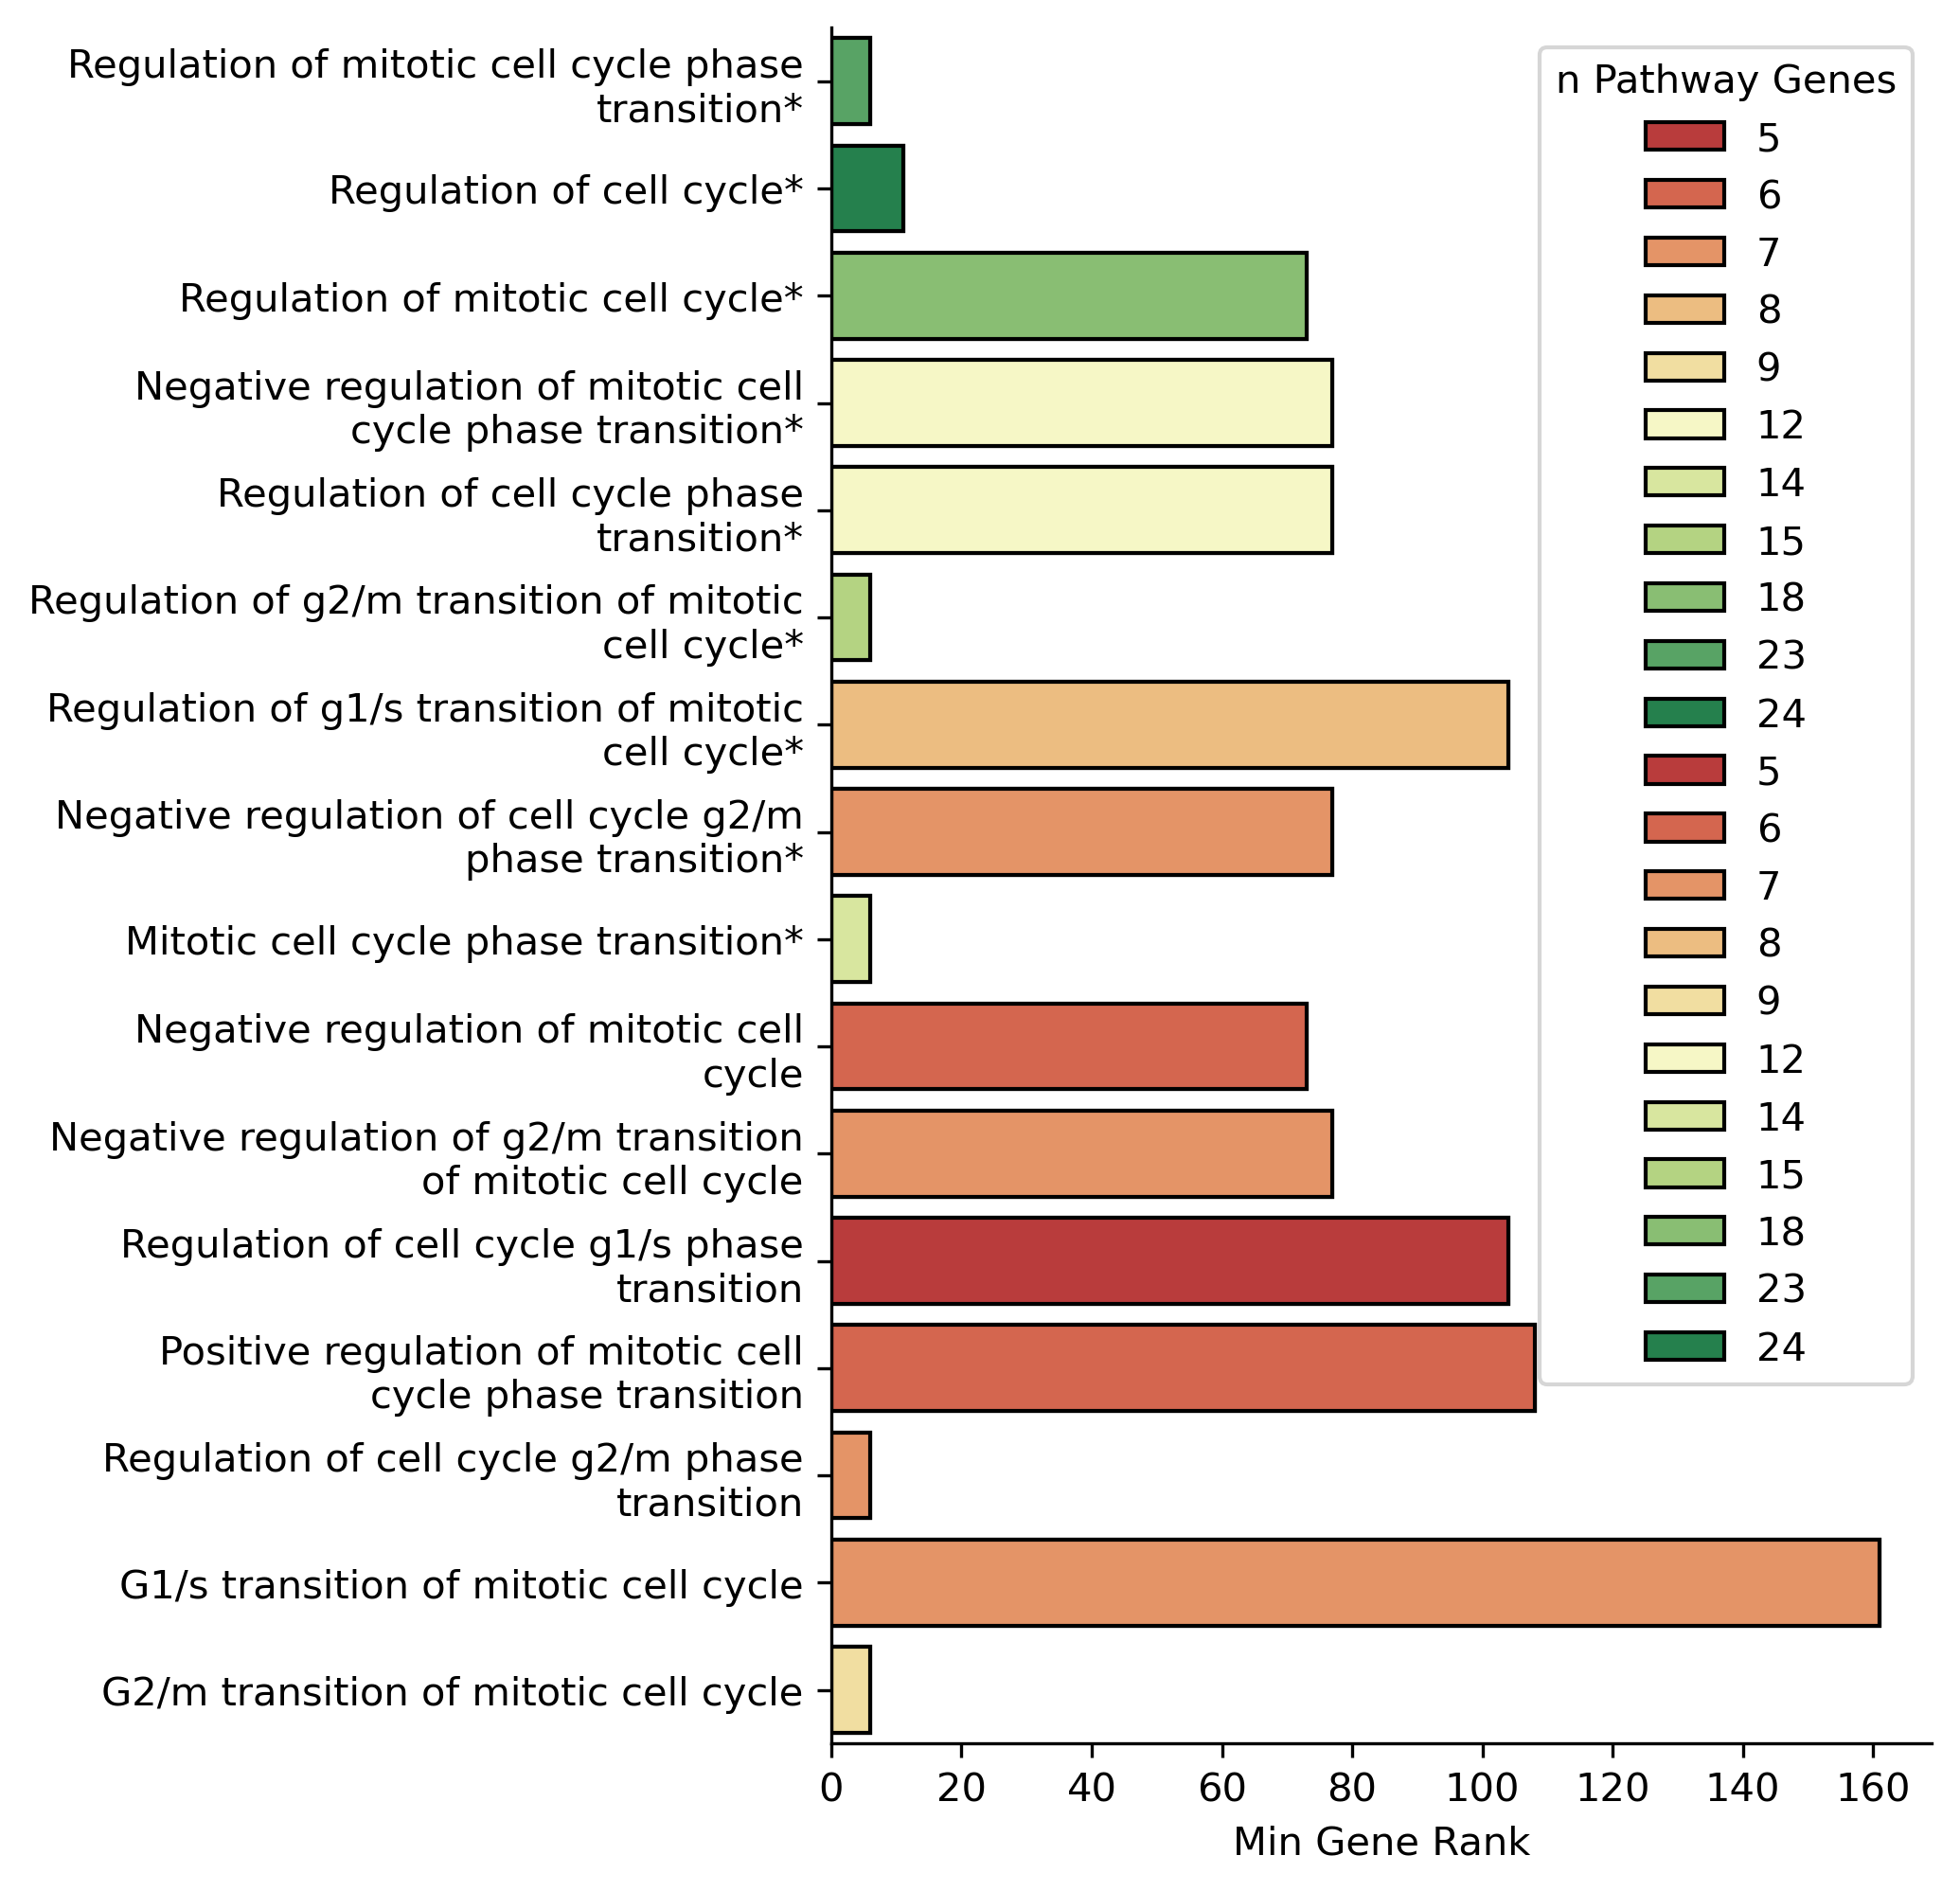

In [34]:
def wrap_ylabels(ax, width):
    labels = []
    for label in ax.get_yticklabels():
        text = label.get_text()
        labels.append(textwrap.fill(text, width=width,
                      break_long_words=False))
    ax.set_yticklabels(labels, rotation=0)

edf = gget.enrichr(G5, database=db)
thresh = 0.01
alpha = 0.05

pdf = edf.copy()
pdf = pdf[pdf['adj_p_val'] <= alpha]

pdf['n_gene'] = pdf['overlapping_genes'].apply(lambda x: len(x))
pdf['logp'] = -1 * np.log10(pdf['adj_p_val'])
pdf['name'] = pdf['path_name'].apply(lambda x: x.split("(")[0].capitalize())
pdf['name_sig'] = pdf[['name', 'adj_p_val']].apply(lambda x: x[0].strip() + "*" if x[1] < thresh else x[0], axis=1)

# get the cell cycle processes
pdf['cell_cycle'] = pdf['name'].apply(lambda x: 1 if 'cell cycle' in x else 0)
pdf = pdf[pdf['cell_cycle'] == 1]

pdf['rank'] = pdf['overlapping_genes'].apply(lambda x: ss2015['sensors'][ss2015['sensors']['gene'].isin(x)]['rank'].min())

plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 5, 8

sns.barplot(data=pdf, 
            y='name_sig',
            x='rank',
            hue='n_gene',
            dodge=False,
            ec='k',
            palette='RdYlGn')

plt.ylabel("")
plt.xlabel("Min Gene Rank")
wrap_ylabels(plt.gca(), width=40)
sns.despine()
sns.move_legend(plt.gca(), 
                loc='upper right',
                title='n Pathway Genes')
pdf.head()
thresh = 0.01
alpha = 0.05

pdf = edf.copy()
pdf = pdf[pdf['adj_p_val'] <= alpha]

pdf['n_gene'] = pdf['overlapping_genes'].apply(lambda x: len(x))
pdf['logp'] = -1 * np.log10(pdf['adj_p_val'])
pdf['name'] = pdf['path_name'].apply(lambda x: x.split("(")[0].capitalize())
pdf['name_sig'] = pdf[['name', 'adj_p_val']].apply(lambda x: x[0].strip() + "*" if x[1] < thresh else x[0], axis=1)

# get the cell cycle processes
pdf['cell_cycle'] = pdf['name'].apply(lambda x: 1 if 'cell cycle' in x else 0)
pdf = pdf[pdf['cell_cycle'] == 1]

pdf['rank'] = pdf['overlapping_genes'].apply(lambda x: ss2015['sensors'][ss2015['sensors']['gene'].isin(x)]['rank'].min())

plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 5, 8

sns.barplot(data=pdf, 
            y='name_sig',
            x='rank',
            hue='n_gene',
            dodge=False,
            ec='k',
            palette='RdYlGn')

plt.ylabel("")
plt.xlabel("Min Gene Rank")
wrap_ylabels(plt.gca(), width=40)
sns.despine()
sns.move_legend(plt.gca(), 
                loc='upper right',
                title='n Pathway Genes')
pdf.head()

Thu Nov 16 17:19:39 2023 INFO Performing Enichr analysis using database GO_Biological_Process_2021.


,rank,path_name,p_val,z_score,combined_score,overlapping_genes,adj_p_val,database,n_gene,logp,name,name_sig,cell_cycle
1099,7567.0,regulation of metaphase/anaphase transition of cell cycle (GO:1902099),0.183377,5.580590,9.465855,[HECW2],0.406988,GO_Biological_Process_2021,1,0.390418,Regulation of metaphase/anaphase transition of cell cycle,Regulation of metaphase/anaphase transition of cell cycle,1
1183,575.0,regulation of nuclear cell cycle DNA replication (GO:0033262),0.203801,4.882766,7.766586,[AICDA],0.426939,GO_Biological_Process_2021,1,0.369634,Regulation of nuclear cell cycle dna replication,Regulation of nuclear cell cycle dna replication,1
1230,6972.0,positive regulation of cell cycle G1/S phase transition (GO:1902808),0.217731,2.369113,3.611697,"[PLCG2, AIF1]",0.440661,GO_Biological_Process_2021,2,0.355896,Positive regulation of cell cycle g1/s phase transition,Positive regulation of cell cycle g1/s phase transition,1
1289,272.0,regulation of cell cycle G1/S phase transition (GO:1902806),0.226987,2.299315,3.409565,"[PLCG2, PTPN6]",0.444349,GO_Biological_Process_2021,2,0.352276,Regulation of cell cycle g1/s phase transition,Regulation of cell cycle g1/s phase transition,1


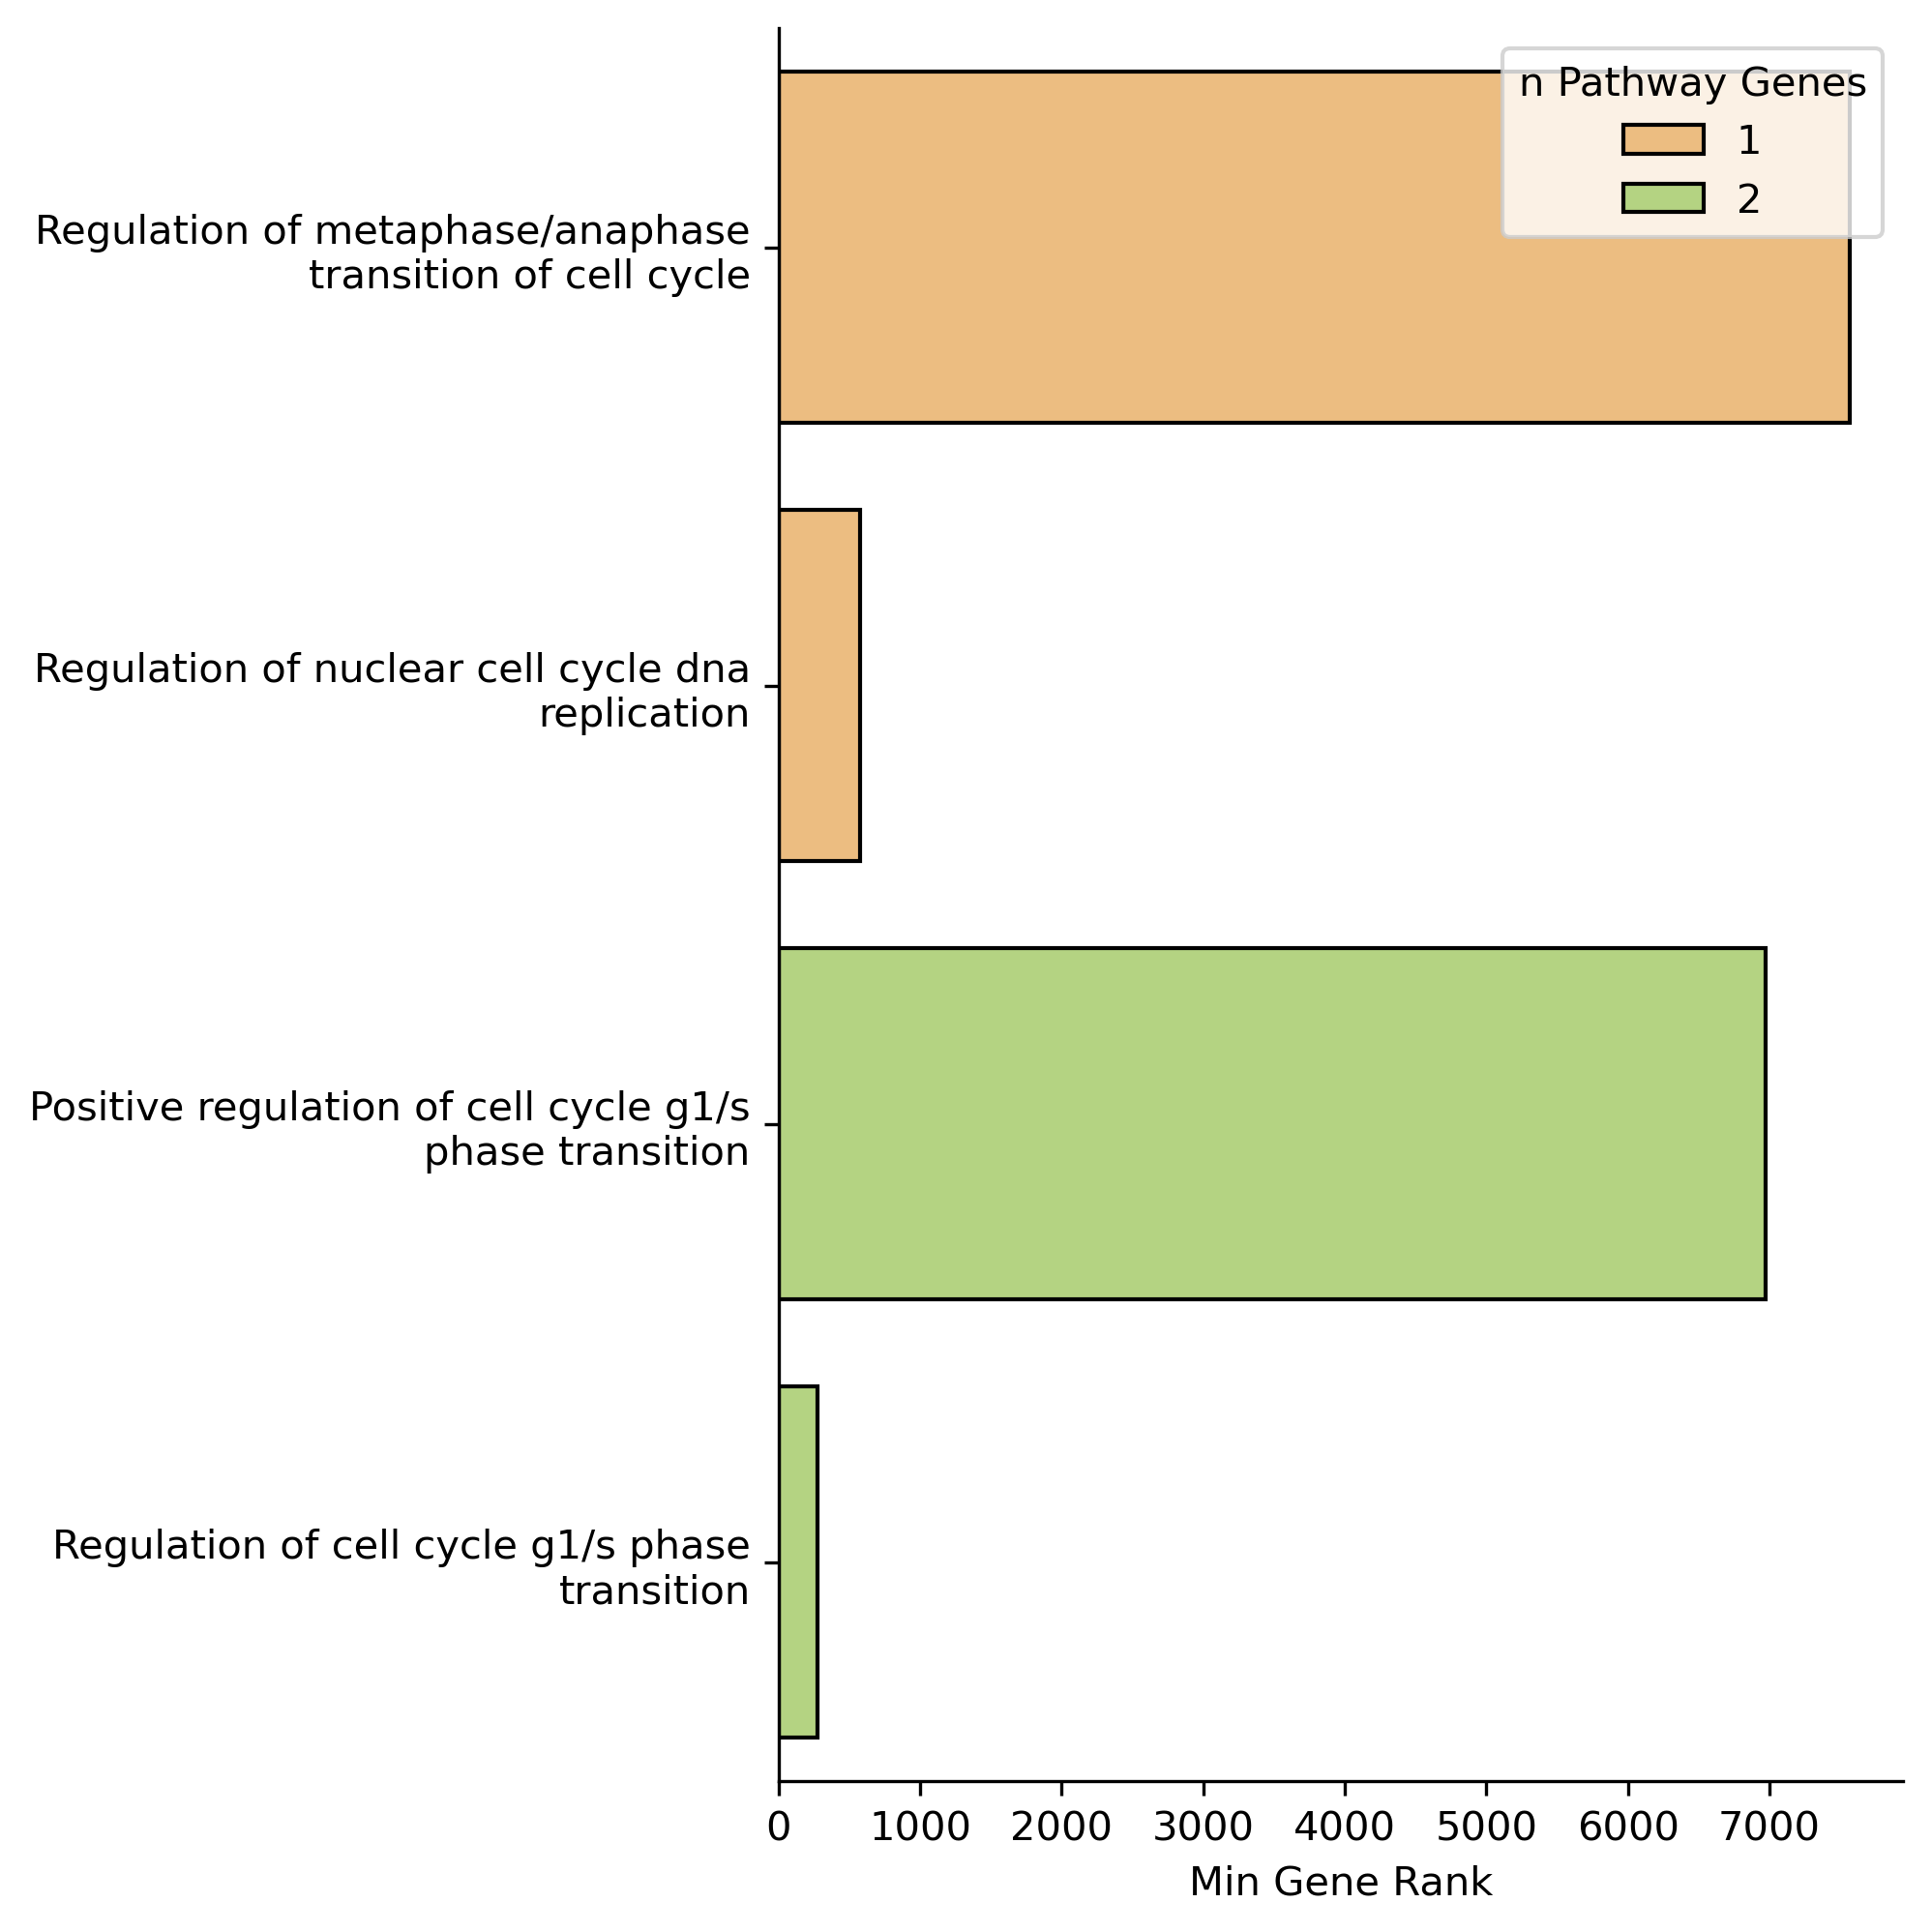

In [43]:
edf = gget.enrichr(G7, database=db)
thresh = 0.01
alpha = 0.51

pdf = edf.copy()
pdf = pdf[pdf['adj_p_val'] <= alpha]

pdf['n_gene'] = pdf['overlapping_genes'].apply(lambda x: len(x))
pdf['logp'] = -1 * np.log10(pdf['adj_p_val'])
pdf['name'] = pdf['path_name'].apply(lambda x: x.split("(")[0].capitalize())
pdf['name_sig'] = pdf[['name', 'adj_p_val']].apply(lambda x: x[0].strip() + "*" if x[1] < thresh else x[0], axis=1)

# get the cell cycle processes
pdf['cell_cycle'] = pdf['name'].apply(lambda x: 1 if 'cell cycle' in x else 0)
pdf = pdf[pdf['cell_cycle'] == 1]

pdf['rank'] = pdf['overlapping_genes'].apply(lambda x: ss2015['sensors'][ss2015['sensors']['gene'].isin(x)]['rank'].min())

plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 5, 8

sns.barplot(data=pdf, 
            y='name_sig',
            x='rank',
            hue='n_gene',
            dodge=False,
            ec='k',
            palette='RdYlGn')

plt.ylabel("")
plt.xlabel("Min Gene Rank")
wrap_ylabels(plt.gca(), width=40)
sns.despine()
sns.move_legend(plt.gca(), 
                loc='upper right',
                title='n Pathway Genes')
pdf.head()

In [32]:
edf

,rank,path_name,p_val,z_score,combined_score,overlapping_genes,adj_p_val,database
0,1,B cell receptor signaling pathway (GO:0050853),6.280899e-24,57.994048,3098.304683,"[BLK, MEF2C, SYK, PRKCB, CD79B, LAT2, CD79A, IGLL5, PTPRC, TEC, LCK, CD19, BLNK, PLCG2, BCL2, BT...",1.594720e-20,GO_Biological_Process_2021
1,2,cytokine-mediated signaling pathway (GO:0019221),6.868969e-23,5.091210,259.816874,"[CD86, CXCL9, SPI1, TNFRSF13B, CD80, ITGB2, IFI30, TNF, GRAP2, ITGAX, TNFSF11, TNFRSF8, TNFRSF4,...",8.720156e-20,GO_Biological_Process_2021
2,3,antigen receptor-mediated signaling pathway (GO:0050851),5.736810e-22,10.076313,492.832172,"[BLK, WAS, PTPN22, CD3E, CD79B, CD79A, GRAP2, CD19, INPP5D, PLCG2, BLNK, NCKAP1L, HLA-DQA2, HLA-...",4.855253e-19,GO_Biological_Process_2021
3,4,cellular response to cytokine stimulus (GO:0071345),6.421560e-17,4.784252,178.377401,"[CD86, CD80, DOCK8, ITGB2, TNF, TCL1A, GRAP2, ITGAX, TNFSF11, SYK, DAPK1, IL16, NPNT, VAV1, FCER...",4.076085e-14,GO_Biological_Process_2021
4,5,regulation of immune response (GO:0050776),1.293417e-16,8.289733,303.272203,"[ITGB2, ICAM2, PTPN22, CD3E, ITGAL, SPN, IL4I1, CD19, SLAMF7, SLAMF6, ITGB7, LAIR1, VCAM1, SYK, ...",6.567972e-14,GO_Biological_Process_2021
...,...,...,...,...,...,...,...,...
2534,2535,protein polyubiquitination (GO:0000209),9.969578e-01,0.246988,0.000753,"[HECW2, BCL2]",9.985309e-01,GO_Biological_Process_2021
2535,2536,ubiquitin-dependent protein catabolic process (GO:0006511),9.987865e-01,0.218465,0.000265,"[HECW2, ASB2]",9.995119e-01,GO_Biological_Process_2021
2536,2537,protein deubiquitination (GO:0016579),9.988899e-01,0.144906,0.000161,[ATXN3L],9.995119e-01,GO_Biological_Process_2021
2537,2538,protein modification by small protein removal (GO:0070646),9.991182e-01,0.140098,0.000124,[ATXN3L],9.995119e-01,GO_Biological_Process_2021


In [24]:
ss2015

{'sensors':          gene                 ev1    weight    rank
 2480    GAPDH  0.451304+0.000000j  0.451304     1.0
 6966   TMSB4X  0.343204+0.000000j  0.343204     2.0
 573       B2M  0.250874+0.000000j  0.250874     3.0
 2927  HLA-DRA  0.238704+0.000000j  0.238704     4.0
 2433      FTL  0.212981+0.000000j  0.212981     5.0
 ...       ...                 ...       ...     ...
 4711  PCDHGC3 -0.002543+0.000000j -0.002543  8108.0
 4390      NMB -0.002548+0.000000j -0.002548  8109.0
 4617    OXCT2 -0.002552+0.000000j -0.002552  8110.0
 6994  TNFSF13 -0.002555+0.000000j -0.002555  8111.0
 651   BHLHA15 -0.002565+0.000000j -0.002565  8112.0
 
 [8112 rows x 4 columns],
 'dmd': {'A': array([[ 6.66767218e-06, -2.60496550e-06,  8.69078538e-06, ...,
           2.87608269e-06,  7.55024785e-06,  6.39162608e-06],
         [ 1.54711371e-08,  1.87971790e-05,  4.29734948e-07, ...,
          -2.08547646e-05,  3.28841500e-06,  3.40422099e-06],
         [ 5.98954740e-06, -4.04800739e-06,  8.28606234e-

In [9]:
ss2015['sensors']

,gene,ev1,weight,rank
2480,GAPDH,0.451304+0.000000j,0.451304,1.0
6966,TMSB4X,0.343204+0.000000j,0.343204,2.0
573,B2M,0.250874+0.000000j,0.250874,3.0
2927,HLA-DRA,0.238704+0.000000j,0.238704,4.0
2433,FTL,0.212981+0.000000j,0.212981,5.0
...,...,...,...,...
4711,PCDHGC3,-0.002543+0.000000j,-0.002543,8108.0
4390,NMB,-0.002548+0.000000j,-0.002548,8109.0
4617,OXCT2,-0.002552+0.000000j,-0.002552,8110.0
6994,TNFSF13,-0.002555+0.000000j,-0.002555,8111.0


In [13]:
ss2017['sensors']

,gene,ev1,weight,rank
6042,SIRPG,0.002753+0.000000j,0.002753,22.0
104,ACY3,0.002753+0.000000j,0.002753,22.0
3493,LGALS14,0.002753+0.000000j,0.002753,22.0
3441,LAIR1,0.002753+0.000000j,0.002753,22.0
996,CCL22,0.002753+0.000000j,0.002753,22.0
...,...,...,...,...
6965,TMSB10,-0.186987+0.000000j,-0.186987,8108.0
2480,GAPDH,-0.233729+0.000000j,-0.233729,8109.0
7497,VIM,-0.271955+0.000000j,-0.271955,8110.0
5790,S100A6,-0.294759+0.000000j,-0.294759,8111.0


In [ ]:
subset_tpm = tpm.loc[high_exp_genes]
subset_tpm

In [ ]:
target = 1e6
threshold = 0.5
rank = 7
tpm = nb.TPM(df, gf, target=target)

# get highly expressed genes
tpm_dist = tpm.mean(axis=1)
mask = (tpm_dist > threshold)
high_exp_genes = tpm_dist[mask].index.to_list()

# filter and convert to fold changes
d = tpm[tpm.index.isin(high_exp_genes)]
dmd_data_2017 = nb.data2DMD2017(d)
print(f"{dmd_data.shape=}")

dmd_res = hasnain_DMD.dmd(dmd_data, rank=rank)

print(f"{dmd_res['A'].shape=}")
print(f"{dmd_res['Atilde'].shape=}")
print(f"{dmd_res['u_r'].shape=}")
print(f"{dmd_res['L'].shape=}")
print(f"{dmd_res['W'].shape=}")
print(f"{dmd_res['Phi'].shape=}")
print(f"{dmd_res['amplitudes'][0].shape=}")
print('done')

In [7]:
ss2015['sensors']

,gene,ev1,weight,rank
0,TSPAN6,0.009513+0.000000j,0.009513,1.0
1,MMP2,0.009512+0.000000j,0.009512,2.0
2,KIRREL1,0.009512+0.000000j,0.009512,4.0
3,CNRIP1,0.009512+0.000000j,0.009512,4.0
4,ANTXR1,0.009512+0.000000j,0.009512,4.0
...,...,...,...,...
1765,EEF1B2,-0.235144+0.000000j,-0.235144,1766.0
1766,HLA-B,-0.241201+0.000000j,-0.241201,1767.0
1767,RACK1,-0.243510+0.000000j,-0.243510,1768.0
1768,PTMA,-0.281017+0.000000j,-0.281017,1769.0


# Figures

[    1     2     3     4     5     6     7     8     9    10    11    12
    13    15    16    18    20    22    24    27    29    33    36    40
    44    48    54    59    65    72    80    88    97   107   119   131
   145   160   177   195   216   238   263   291   321   355   392   433
   478   528   584   645   712   787   869   960  1060  1171  1294  1429
  1579  1744  1926  2128  2350  2596  2868  3168  3500  3866  4270  4717
  5211  5756  6358  7024  7758  8570  9467 10458 11552 12761 14096 15571
 17200 19000]
1


/home/jpic/.local/lib/python3.9/site-packages/pandas/core/internals/blocks.py:329: RuntimeWarning: divide by zero encountered in log
  result = func(self.values, **kwargs)
/home/jpic/.local/lib/python3.9/site-packages/pandas/core/internals/blocks.py:329: RuntimeWarning: divide by zero encountered in log
  result = func(self.values, **kwargs)


2
3


/home/jpic/.local/lib/python3.9/site-packages/pandas/core/internals/blocks.py:329: RuntimeWarning: divide by zero encountered in log
  result = func(self.values, **kwargs)
/home/jpic/.local/lib/python3.9/site-packages/pandas/core/internals/blocks.py:329: RuntimeWarning: divide by zero encountered in log
  result = func(self.values, **kwargs)
/home/jpic/.local/lib/python3.9/site-packages/pandas/core/internals/blocks.py:329: RuntimeWarning: divide by zero encountered in log
  result = func(self.values, **kwargs)
/home/jpic/.local/lib/python3.9/site-packages/pandas/core/internals/blocks.py:329: RuntimeWarning: divide by zero encountered in log
  result = func(self.values, **kwargs)
/home/jpic/.local/lib/python3.9/site-packages/pandas/core/internals/blocks.py:329: RuntimeWarning: divide by zero encountered in log
  result = func(self.values, **kwargs)
/home/jpic/.local/lib/python3.9/site-packages/pandas/core/internals/blocks.py:329: RuntimeWarning: divide by zero encountered in log
  resul

4
5


/home/jpic/.local/lib/python3.9/site-packages/pandas/core/internals/blocks.py:329: RuntimeWarning: divide by zero encountered in log
  result = func(self.values, **kwargs)
/home/jpic/.local/lib/python3.9/site-packages/pandas/core/internals/blocks.py:329: RuntimeWarning: divide by zero encountered in log
  result = func(self.values, **kwargs)
/home/jpic/.local/lib/python3.9/site-packages/pandas/core/internals/blocks.py:329: RuntimeWarning: divide by zero encountered in log
  result = func(self.values, **kwargs)


6
7


/home/jpic/.local/lib/python3.9/site-packages/pandas/core/internals/blocks.py:329: RuntimeWarning: divide by zero encountered in log
  result = func(self.values, **kwargs)
/home/jpic/.local/lib/python3.9/site-packages/pandas/core/internals/blocks.py:329: RuntimeWarning: divide by zero encountered in log
  result = func(self.values, **kwargs)
/home/jpic/.local/lib/python3.9/site-packages/pandas/core/internals/blocks.py:329: RuntimeWarning: divide by zero encountered in log
  result = func(self.values, **kwargs)


8
9


/home/jpic/.local/lib/python3.9/site-packages/pandas/core/internals/blocks.py:329: RuntimeWarning: divide by zero encountered in log
  result = func(self.values, **kwargs)
/home/jpic/.local/lib/python3.9/site-packages/pandas/core/internals/blocks.py:329: RuntimeWarning: divide by zero encountered in log
  result = func(self.values, **kwargs)
/home/jpic/.local/lib/python3.9/site-packages/pandas/core/internals/blocks.py:329: RuntimeWarning: divide by zero encountered in log
  result = func(self.values, **kwargs)
/home/jpic/.local/lib/python3.9/site-packages/pandas/core/internals/blocks.py:329: RuntimeWarning: divide by zero encountered in log
  result = func(self.values, **kwargs)
/home/jpic/.local/lib/python3.9/site-packages/pandas/core/internals/blocks.py:329: RuntimeWarning: divide by zero encountered in log
  result = func(self.values, **kwargs)
/home/jpic/.local/lib/python3.9/site-packages/pandas/core/internals/blocks.py:329: RuntimeWarning: divide by zero encountered in log
  resul

10
11


/home/jpic/.local/lib/python3.9/site-packages/pandas/core/internals/blocks.py:329: RuntimeWarning: divide by zero encountered in log
  result = func(self.values, **kwargs)
/home/jpic/.local/lib/python3.9/site-packages/pandas/core/internals/blocks.py:329: RuntimeWarning: divide by zero encountered in log
  result = func(self.values, **kwargs)
/home/jpic/.local/lib/python3.9/site-packages/pandas/core/internals/blocks.py:329: RuntimeWarning: divide by zero encountered in log
  result = func(self.values, **kwargs)


12
13

/home/jpic/.local/lib/python3.9/site-packages/pandas/core/internals/blocks.py:329: RuntimeWarning: divide by zero encountered in log
  result = func(self.values, **kwargs)
/home/jpic/.local/lib/python3.9/site-packages/pandas/core/internals/blocks.py:329: RuntimeWarning: divide by zero encountered in log
  result = func(self.values, **kwargs)
/home/jpic/.local/lib/python3.9/site-packages/pandas/core/internals/blocks.py:329: RuntimeWarning: divide by zero encountered in log
  result = func(self.values, **kwargs)



15


/home/jpic/.local/lib/python3.9/site-packages/pandas/core/internals/blocks.py:329: RuntimeWarning: divide by zero encountered in log
  result = func(self.values, **kwargs)
/home/jpic/.local/lib/python3.9/site-packages/pandas/core/internals/blocks.py:329: RuntimeWarning: divide by zero encountered in log
  result = func(self.values, **kwargs)
/home/jpic/.local/lib/python3.9/site-packages/pandas/core/internals/blocks.py:329: RuntimeWarning: divide by zero encountered in log
  result = func(self.values, **kwargs)
/home/jpic/.local/lib/python3.9/site-packages/pandas/core/internals/blocks.py:329: RuntimeWarning: divide by zero encountered in log
  result = func(self.values, **kwargs)


16
18


/home/jpic/.local/lib/python3.9/site-packages/pandas/core/internals/blocks.py:329: RuntimeWarning: divide by zero encountered in log
  result = func(self.values, **kwargs)
/home/jpic/.local/lib/python3.9/site-packages/pandas/core/internals/blocks.py:329: RuntimeWarning: divide by zero encountered in log
  result = func(self.values, **kwargs)


20
22


/home/jpic/.local/lib/python3.9/site-packages/pandas/core/internals/blocks.py:329: RuntimeWarning: divide by zero encountered in log
  result = func(self.values, **kwargs)
/home/jpic/.local/lib/python3.9/site-packages/pandas/core/internals/blocks.py:329: RuntimeWarning: divide by zero encountered in log
  result = func(self.values, **kwargs)
/home/jpic/.local/lib/python3.9/site-packages/pandas/core/internals/blocks.py:329: RuntimeWarning: divide by zero encountered in log
  result = func(self.values, **kwargs)
/home/jpic/.local/lib/python3.9/site-packages/pandas/core/internals/blocks.py:329: RuntimeWarning: divide by zero encountered in log
  result = func(self.values, **kwargs)
/home/jpic/.local/lib/python3.9/site-packages/pandas/core/internals/blocks.py:329: RuntimeWarning: divide by zero encountered in log
  result = func(self.values, **kwargs)
/home/jpic/.local/lib/python3.9/site-packages/pandas/core/internals/blocks.py:329: RuntimeWarning: divide by zero encountered in log
  resul

24
27


/home/jpic/.local/lib/python3.9/site-packages/pandas/core/internals/blocks.py:329: RuntimeWarning: divide by zero encountered in log
  result = func(self.values, **kwargs)
/home/jpic/.local/lib/python3.9/site-packages/pandas/core/internals/blocks.py:329: RuntimeWarning: divide by zero encountered in log
  result = func(self.values, **kwargs)
/home/jpic/.local/lib/python3.9/site-packages/pandas/core/internals/blocks.py:329: RuntimeWarning: divide by zero encountered in log
  result = func(self.values, **kwargs)
/home/jpic/.local/lib/python3.9/site-packages/pandas/core/internals/blocks.py:329: RuntimeWarning: divide by zero encountered in log
  result = func(self.values, **kwargs)


29
33


/home/jpic/.local/lib/python3.9/site-packages/pandas/core/internals/blocks.py:329: RuntimeWarning: divide by zero encountered in log
  result = func(self.values, **kwargs)
/home/jpic/.local/lib/python3.9/site-packages/pandas/core/internals/blocks.py:329: RuntimeWarning: divide by zero encountered in log
  result = func(self.values, **kwargs)
/home/jpic/.local/lib/python3.9/site-packages/pandas/core/internals/blocks.py:329: RuntimeWarning: divide by zero encountered in log
  result = func(self.values, **kwargs)
/home/jpic/.local/lib/python3.9/site-packages/pandas/core/internals/blocks.py:329: RuntimeWarning: divide by zero encountered in log
  result = func(self.values, **kwargs)


36
40


/home/jpic/.local/lib/python3.9/site-packages/pandas/core/internals/blocks.py:329: RuntimeWarning: divide by zero encountered in log
  result = func(self.values, **kwargs)
/home/jpic/.local/lib/python3.9/site-packages/pandas/core/internals/blocks.py:329: RuntimeWarning: divide by zero encountered in log
  result = func(self.values, **kwargs)
/home/jpic/.local/lib/python3.9/site-packages/pandas/core/internals/blocks.py:329: RuntimeWarning: divide by zero encountered in log
  result = func(self.values, **kwargs)


44
48


/home/jpic/.local/lib/python3.9/site-packages/pandas/core/internals/blocks.py:329: RuntimeWarning: divide by zero encountered in log
  result = func(self.values, **kwargs)
/home/jpic/.local/lib/python3.9/site-packages/pandas/core/internals/blocks.py:329: RuntimeWarning: divide by zero encountered in log
  result = func(self.values, **kwargs)
/home/jpic/.local/lib/python3.9/site-packages/pandas/core/internals/blocks.py:329: RuntimeWarning: divide by zero encountered in log
  result = func(self.values, **kwargs)


54
59


/home/jpic/.local/lib/python3.9/site-packages/pandas/core/internals/blocks.py:329: RuntimeWarning: divide by zero encountered in log
  result = func(self.values, **kwargs)
/home/jpic/.local/lib/python3.9/site-packages/pandas/core/internals/blocks.py:329: RuntimeWarning: divide by zero encountered in log
  result = func(self.values, **kwargs)
/home/jpic/.local/lib/python3.9/site-packages/pandas/core/internals/blocks.py:329: RuntimeWarning: divide by zero encountered in log
  result = func(self.values, **kwargs)
/home/jpic/.local/lib/python3.9/site-packages/pandas/core/internals/blocks.py:329: RuntimeWarning: divide by zero encountered in log
  result = func(self.values, **kwargs)
/home/jpic/.local/lib/python3.9/site-packages/pandas/core/internals/blocks.py:329: RuntimeWarning: divide by zero encountered in log
  result = func(self.values, **kwargs)
/home/jpic/.local/lib/python3.9/site-packages/pandas/core/internals/blocks.py:329: RuntimeWarning: divide by zero encountered in log
  resul

65
72


/home/jpic/.local/lib/python3.9/site-packages/pandas/core/internals/blocks.py:329: RuntimeWarning: divide by zero encountered in log
  result = func(self.values, **kwargs)
/home/jpic/.local/lib/python3.9/site-packages/pandas/core/internals/blocks.py:329: RuntimeWarning: divide by zero encountered in log
  result = func(self.values, **kwargs)
/home/jpic/.local/lib/python3.9/site-packages/pandas/core/internals/blocks.py:329: RuntimeWarning: divide by zero encountered in log
  result = func(self.values, **kwargs)
/home/jpic/.local/lib/python3.9/site-packages/pandas/core/internals/blocks.py:329: RuntimeWarning: divide by zero encountered in log
  result = func(self.values, **kwargs)


80
88


/home/jpic/.local/lib/python3.9/site-packages/pandas/core/internals/blocks.py:329: RuntimeWarning: divide by zero encountered in log
  result = func(self.values, **kwargs)
/home/jpic/.local/lib/python3.9/site-packages/pandas/core/internals/blocks.py:329: RuntimeWarning: divide by zero encountered in log
  result = func(self.values, **kwargs)
/home/jpic/.local/lib/python3.9/site-packages/pandas/core/internals/blocks.py:329: RuntimeWarning: divide by zero encountered in log
  result = func(self.values, **kwargs)


97
107


/home/jpic/.local/lib/python3.9/site-packages/pandas/core/internals/blocks.py:329: RuntimeWarning: divide by zero encountered in log
  result = func(self.values, **kwargs)
/home/jpic/.local/lib/python3.9/site-packages/pandas/core/internals/blocks.py:329: RuntimeWarning: divide by zero encountered in log
  result = func(self.values, **kwargs)
/home/jpic/.local/lib/python3.9/site-packages/pandas/core/internals/blocks.py:329: RuntimeWarning: divide by zero encountered in log
  result = func(self.values, **kwargs)


119
131


/home/jpic/.local/lib/python3.9/site-packages/pandas/core/internals/blocks.py:329: RuntimeWarning: divide by zero encountered in log
  result = func(self.values, **kwargs)
/home/jpic/.local/lib/python3.9/site-packages/pandas/core/internals/blocks.py:329: RuntimeWarning: divide by zero encountered in log
  result = func(self.values, **kwargs)
/home/jpic/.local/lib/python3.9/site-packages/pandas/core/internals/blocks.py:329: RuntimeWarning: divide by zero encountered in log
  result = func(self.values, **kwargs)
/home/jpic/.local/lib/python3.9/site-packages/pandas/core/internals/blocks.py:329: RuntimeWarning: divide by zero encountered in log
  result = func(self.values, **kwargs)
/home/jpic/.local/lib/python3.9/site-packages/pandas/core/internals/blocks.py:329: RuntimeWarning: divide by zero encountered in log
  result = func(self.values, **kwargs)
/home/jpic/.local/lib/python3.9/site-packages/pandas/core/internals/blocks.py:329: RuntimeWarning: divide by zero encountered in log
  resul

145
160


/home/jpic/.local/lib/python3.9/site-packages/pandas/core/internals/blocks.py:329: RuntimeWarning: divide by zero encountered in log
  result = func(self.values, **kwargs)
/home/jpic/.local/lib/python3.9/site-packages/pandas/core/internals/blocks.py:329: RuntimeWarning: divide by zero encountered in log
  result = func(self.values, **kwargs)
/home/jpic/.local/lib/python3.9/site-packages/pandas/core/internals/blocks.py:329: RuntimeWarning: divide by zero encountered in log
  result = func(self.values, **kwargs)


177
195


/home/jpic/.local/lib/python3.9/site-packages/pandas/core/internals/blocks.py:329: RuntimeWarning: divide by zero encountered in log
  result = func(self.values, **kwargs)
/home/jpic/.local/lib/python3.9/site-packages/pandas/core/internals/blocks.py:329: RuntimeWarning: divide by zero encountered in log
  result = func(self.values, **kwargs)
/home/jpic/.local/lib/python3.9/site-packages/pandas/core/internals/blocks.py:329: RuntimeWarning: divide by zero encountered in log
  result = func(self.values, **kwargs)


216
238


/home/jpic/.local/lib/python3.9/site-packages/pandas/core/internals/blocks.py:329: RuntimeWarning: divide by zero encountered in log
  result = func(self.values, **kwargs)
/home/jpic/.local/lib/python3.9/site-packages/pandas/core/internals/blocks.py:329: RuntimeWarning: divide by zero encountered in log
  result = func(self.values, **kwargs)
/home/jpic/.local/lib/python3.9/site-packages/pandas/core/internals/blocks.py:329: RuntimeWarning: divide by zero encountered in log
  result = func(self.values, **kwargs)
/home/jpic/.local/lib/python3.9/site-packages/pandas/core/internals/blocks.py:329: RuntimeWarning: divide by zero encountered in log
  result = func(self.values, **kwargs)
/home/jpic/.local/lib/python3.9/site-packages/pandas/core/internals/blocks.py:329: RuntimeWarning: divide by zero encountered in log
  result = func(self.values, **kwargs)
/home/jpic/.local/lib/python3.9/site-packages/pandas/core/internals/blocks.py:329: RuntimeWarning: divide by zero encountered in log
  resul

263
291


/home/jpic/.local/lib/python3.9/site-packages/pandas/core/internals/blocks.py:329: RuntimeWarning: divide by zero encountered in log
  result = func(self.values, **kwargs)
/home/jpic/.local/lib/python3.9/site-packages/pandas/core/internals/blocks.py:329: RuntimeWarning: divide by zero encountered in log
  result = func(self.values, **kwargs)
/home/jpic/.local/lib/python3.9/site-packages/pandas/core/internals/blocks.py:329: RuntimeWarning: divide by zero encountered in log
  result = func(self.values, **kwargs)


321
355

/home/jpic/.local/lib/python3.9/site-packages/pandas/core/internals/blocks.py:329: RuntimeWarning: divide by zero encountered in log
  result = func(self.values, **kwargs)
/home/jpic/.local/lib/python3.9/site-packages/pandas/core/internals/blocks.py:329: RuntimeWarning: divide by zero encountered in log
  result = func(self.values, **kwargs)
/home/jpic/.local/lib/python3.9/site-packages/pandas/core/internals/blocks.py:329: RuntimeWarning: divide by zero encountered in log
  result = func(self.values, **kwargs)



392

/home/jpic/.local/lib/python3.9/site-packages/pandas/core/internals/blocks.py:329: RuntimeWarning: divide by zero encountered in log
  result = func(self.values, **kwargs)
/home/jpic/.local/lib/python3.9/site-packages/pandas/core/internals/blocks.py:329: RuntimeWarning: divide by zero encountered in log
  result = func(self.values, **kwargs)



433
478

/home/jpic/.local/lib/python3.9/site-packages/pandas/core/internals/blocks.py:329: RuntimeWarning: divide by zero encountered in log
  result = func(self.values, **kwargs)
/home/jpic/.local/lib/python3.9/site-packages/pandas/core/internals/blocks.py:329: RuntimeWarning: divide by zero encountered in log
  result = func(self.values, **kwargs)


/home/jpic/.local/lib/python3.9/site-packages/pandas/core/internals/blocks.py:329: RuntimeWarning: divide by zero encountered in log
  result = func(self.values, **kwargs)
/home/jpic/.local/lib/python3.9/site-packages/pandas/core/internals/blocks.py:329: RuntimeWarning: divide by zero encountered in log
  result = func(self.values, **kwargs)


528
584


/home/jpic/.local/lib/python3.9/site-packages/pandas/core/internals/blocks.py:329: RuntimeWarning: divide by zero encountered in log
  result = func(self.values, **kwargs)
/home/jpic/.local/lib/python3.9/site-packages/pandas/core/internals/blocks.py:329: RuntimeWarning: divide by zero encountered in log
  result = func(self.values, **kwargs)
/home/jpic/.local/lib/python3.9/site-packages/pandas/core/internals/blocks.py:329: RuntimeWarning: divide by zero encountered in log
  result = func(self.values, **kwargs)
/home/jpic/.local/lib/python3.9/site-packages/pandas/core/internals/blocks.py:329: RuntimeWarning: divide by zero encountered in log
  result = func(self.values, **kwargs)
/home/jpic/.local/lib/python3.9/site-packages/pandas/core/internals/blocks.py:329: RuntimeWarning: divide by zero encountered in log
  result = func(self.values, **kwargs)
/home/jpic/.local/lib/python3.9/site-packages/pandas/core/internals/blocks.py:329: RuntimeWarning: divide by zero encountered in log
  resul

645
712


/home/jpic/.local/lib/python3.9/site-packages/pandas/core/internals/blocks.py:329: RuntimeWarning: divide by zero encountered in log
  result = func(self.values, **kwargs)
/home/jpic/.local/lib/python3.9/site-packages/pandas/core/internals/blocks.py:329: RuntimeWarning: divide by zero encountered in log
  result = func(self.values, **kwargs)


787


/home/jpic/.local/lib/python3.9/site-packages/pandas/core/internals/blocks.py:329: RuntimeWarning: divide by zero encountered in log
  result = func(self.values, **kwargs)
/home/jpic/.local/lib/python3.9/site-packages/pandas/core/internals/blocks.py:329: RuntimeWarning: divide by zero encountered in log
  result = func(self.values, **kwargs)


869


/home/jpic/.local/lib/python3.9/site-packages/pandas/core/internals/blocks.py:329: RuntimeWarning: divide by zero encountered in log
  result = func(self.values, **kwargs)
/home/jpic/.local/lib/python3.9/site-packages/pandas/core/internals/blocks.py:329: RuntimeWarning: divide by zero encountered in log
  result = func(self.values, **kwargs)


960


/home/jpic/.local/lib/python3.9/site-packages/pandas/core/internals/blocks.py:329: RuntimeWarning: divide by zero encountered in log
  result = func(self.values, **kwargs)
/home/jpic/.local/lib/python3.9/site-packages/pandas/core/internals/blocks.py:329: RuntimeWarning: divide by zero encountered in log
  result = func(self.values, **kwargs)


1060


/home/jpic/.local/lib/python3.9/site-packages/pandas/core/internals/blocks.py:329: RuntimeWarning: divide by zero encountered in log
  result = func(self.values, **kwargs)
/home/jpic/.local/lib/python3.9/site-packages/pandas/core/internals/blocks.py:329: RuntimeWarning: divide by zero encountered in log
  result = func(self.values, **kwargs)


1171


/home/jpic/.local/lib/python3.9/site-packages/pandas/core/internals/blocks.py:329: RuntimeWarning: divide by zero encountered in log
  result = func(self.values, **kwargs)
/home/jpic/.local/lib/python3.9/site-packages/pandas/core/internals/blocks.py:329: RuntimeWarning: divide by zero encountered in log
  result = func(self.values, **kwargs)


1294


/home/jpic/.local/lib/python3.9/site-packages/pandas/core/internals/blocks.py:329: RuntimeWarning: divide by zero encountered in log
  result = func(self.values, **kwargs)
/home/jpic/.local/lib/python3.9/site-packages/pandas/core/internals/blocks.py:329: RuntimeWarning: divide by zero encountered in log
  result = func(self.values, **kwargs)


1429


/home/jpic/.local/lib/python3.9/site-packages/pandas/core/internals/blocks.py:329: RuntimeWarning: divide by zero encountered in log
  result = func(self.values, **kwargs)
/home/jpic/.local/lib/python3.9/site-packages/pandas/core/internals/blocks.py:329: RuntimeWarning: divide by zero encountered in log
  result = func(self.values, **kwargs)


1579


/home/jpic/.local/lib/python3.9/site-packages/pandas/core/internals/blocks.py:329: RuntimeWarning: divide by zero encountered in log
  result = func(self.values, **kwargs)
/home/jpic/.local/lib/python3.9/site-packages/pandas/core/internals/blocks.py:329: RuntimeWarning: divide by zero encountered in log
  result = func(self.values, **kwargs)


1744


/home/jpic/.local/lib/python3.9/site-packages/pandas/core/internals/blocks.py:329: RuntimeWarning: divide by zero encountered in log
  result = func(self.values, **kwargs)
/home/jpic/.local/lib/python3.9/site-packages/pandas/core/internals/blocks.py:329: RuntimeWarning: divide by zero encountered in log
  result = func(self.values, **kwargs)


1926


/home/jpic/.local/lib/python3.9/site-packages/pandas/core/internals/blocks.py:329: RuntimeWarning: divide by zero encountered in log
  result = func(self.values, **kwargs)
/home/jpic/.local/lib/python3.9/site-packages/pandas/core/internals/blocks.py:329: RuntimeWarning: divide by zero encountered in log
  result = func(self.values, **kwargs)


2128


/home/jpic/.local/lib/python3.9/site-packages/pandas/core/internals/blocks.py:329: RuntimeWarning: divide by zero encountered in log
  result = func(self.values, **kwargs)
/home/jpic/.local/lib/python3.9/site-packages/pandas/core/internals/blocks.py:329: RuntimeWarning: divide by zero encountered in log
  result = func(self.values, **kwargs)


2350


/home/jpic/.local/lib/python3.9/site-packages/pandas/core/internals/blocks.py:329: RuntimeWarning: divide by zero encountered in log
  result = func(self.values, **kwargs)
/home/jpic/.local/lib/python3.9/site-packages/pandas/core/internals/blocks.py:329: RuntimeWarning: divide by zero encountered in log
  result = func(self.values, **kwargs)


2596


/home/jpic/.local/lib/python3.9/site-packages/pandas/core/internals/blocks.py:329: RuntimeWarning: divide by zero encountered in log
  result = func(self.values, **kwargs)
/home/jpic/.local/lib/python3.9/site-packages/pandas/core/internals/blocks.py:329: RuntimeWarning: divide by zero encountered in log
  result = func(self.values, **kwargs)


2868


/home/jpic/.local/lib/python3.9/site-packages/pandas/core/internals/blocks.py:329: RuntimeWarning: divide by zero encountered in log
  result = func(self.values, **kwargs)
/home/jpic/.local/lib/python3.9/site-packages/pandas/core/internals/blocks.py:329: RuntimeWarning: divide by zero encountered in log
  result = func(self.values, **kwargs)


3168


/home/jpic/.local/lib/python3.9/site-packages/pandas/core/internals/blocks.py:329: RuntimeWarning: divide by zero encountered in log
  result = func(self.values, **kwargs)
/home/jpic/.local/lib/python3.9/site-packages/pandas/core/internals/blocks.py:329: RuntimeWarning: divide by zero encountered in log
  result = func(self.values, **kwargs)


3500


/home/jpic/.local/lib/python3.9/site-packages/pandas/core/internals/blocks.py:329: RuntimeWarning: divide by zero encountered in log
  result = func(self.values, **kwargs)
/home/jpic/.local/lib/python3.9/site-packages/pandas/core/internals/blocks.py:329: RuntimeWarning: divide by zero encountered in log
  result = func(self.values, **kwargs)


3866


/home/jpic/.local/lib/python3.9/site-packages/pandas/core/internals/blocks.py:329: RuntimeWarning: divide by zero encountered in log
  result = func(self.values, **kwargs)
/home/jpic/.local/lib/python3.9/site-packages/pandas/core/internals/blocks.py:329: RuntimeWarning: divide by zero encountered in log
  result = func(self.values, **kwargs)


4270


/home/jpic/.local/lib/python3.9/site-packages/pandas/core/internals/blocks.py:329: RuntimeWarning: divide by zero encountered in log
  result = func(self.values, **kwargs)
/home/jpic/.local/lib/python3.9/site-packages/pandas/core/internals/blocks.py:329: RuntimeWarning: divide by zero encountered in log
  result = func(self.values, **kwargs)


4717


/home/jpic/.local/lib/python3.9/site-packages/pandas/core/internals/blocks.py:329: RuntimeWarning: divide by zero encountered in log
  result = func(self.values, **kwargs)
/home/jpic/.local/lib/python3.9/site-packages/pandas/core/internals/blocks.py:329: RuntimeWarning: divide by zero encountered in log
  result = func(self.values, **kwargs)


5211


/home/jpic/.local/lib/python3.9/site-packages/pandas/core/internals/blocks.py:329: RuntimeWarning: divide by zero encountered in log
  result = func(self.values, **kwargs)
/home/jpic/.local/lib/python3.9/site-packages/pandas/core/internals/blocks.py:329: RuntimeWarning: divide by zero encountered in log
  result = func(self.values, **kwargs)


5756


/home/jpic/.local/lib/python3.9/site-packages/pandas/core/internals/blocks.py:329: RuntimeWarning: divide by zero encountered in log
  result = func(self.values, **kwargs)
/home/jpic/.local/lib/python3.9/site-packages/pandas/core/internals/blocks.py:329: RuntimeWarning: divide by zero encountered in log
  result = func(self.values, **kwargs)


6358


/home/jpic/.local/lib/python3.9/site-packages/pandas/core/internals/blocks.py:329: RuntimeWarning: divide by zero encountered in log
  result = func(self.values, **kwargs)
/home/jpic/.local/lib/python3.9/site-packages/pandas/core/internals/blocks.py:329: RuntimeWarning: divide by zero encountered in log
  result = func(self.values, **kwargs)


7024


/home/jpic/.local/lib/python3.9/site-packages/pandas/core/internals/blocks.py:329: RuntimeWarning: divide by zero encountered in log
  result = func(self.values, **kwargs)
/home/jpic/.local/lib/python3.9/site-packages/pandas/core/internals/blocks.py:329: RuntimeWarning: divide by zero encountered in log
  result = func(self.values, **kwargs)


7758


/home/jpic/.local/lib/python3.9/site-packages/pandas/core/internals/blocks.py:329: RuntimeWarning: divide by zero encountered in log
  result = func(self.values, **kwargs)
/home/jpic/.local/lib/python3.9/site-packages/pandas/core/internals/blocks.py:329: RuntimeWarning: divide by zero encountered in log
  result = func(self.values, **kwargs)


8570


/home/jpic/.local/lib/python3.9/site-packages/pandas/core/internals/blocks.py:329: RuntimeWarning: divide by zero encountered in log
  result = func(self.values, **kwargs)
/home/jpic/.local/lib/python3.9/site-packages/pandas/core/internals/blocks.py:329: RuntimeWarning: divide by zero encountered in log
  result = func(self.values, **kwargs)


9467


/home/jpic/.local/lib/python3.9/site-packages/pandas/core/internals/blocks.py:329: RuntimeWarning: divide by zero encountered in log
  result = func(self.values, **kwargs)
/home/jpic/.local/lib/python3.9/site-packages/pandas/core/internals/blocks.py:329: RuntimeWarning: divide by zero encountered in log
  result = func(self.values, **kwargs)


10458


/home/jpic/.local/lib/python3.9/site-packages/pandas/core/internals/blocks.py:329: RuntimeWarning: divide by zero encountered in log
  result = func(self.values, **kwargs)
/home/jpic/.local/lib/python3.9/site-packages/pandas/core/internals/blocks.py:329: RuntimeWarning: divide by zero encountered in log
  result = func(self.values, **kwargs)


11552


/home/jpic/.local/lib/python3.9/site-packages/pandas/core/internals/blocks.py:329: RuntimeWarning: divide by zero encountered in log
  result = func(self.values, **kwargs)
/home/jpic/.local/lib/python3.9/site-packages/pandas/core/internals/blocks.py:329: RuntimeWarning: divide by zero encountered in log
  result = func(self.values, **kwargs)


12761


/home/jpic/.local/lib/python3.9/site-packages/pandas/core/internals/blocks.py:329: RuntimeWarning: divide by zero encountered in log
  result = func(self.values, **kwargs)
/home/jpic/.local/lib/python3.9/site-packages/pandas/core/internals/blocks.py:329: RuntimeWarning: divide by zero encountered in log
  result = func(self.values, **kwargs)


14096


/home/jpic/.local/lib/python3.9/site-packages/pandas/core/internals/blocks.py:329: RuntimeWarning: divide by zero encountered in log
  result = func(self.values, **kwargs)
/home/jpic/.local/lib/python3.9/site-packages/pandas/core/internals/blocks.py:329: RuntimeWarning: divide by zero encountered in log
  result = func(self.values, **kwargs)


15571


/home/jpic/.local/lib/python3.9/site-packages/pandas/core/internals/blocks.py:329: RuntimeWarning: divide by zero encountered in log
  result = func(self.values, **kwargs)
/home/jpic/.local/lib/python3.9/site-packages/pandas/core/internals/blocks.py:329: RuntimeWarning: divide by zero encountered in log
  result = func(self.values, **kwargs)


17200


/home/jpic/.local/lib/python3.9/site-packages/pandas/core/internals/blocks.py:329: RuntimeWarning: divide by zero encountered in log
  result = func(self.values, **kwargs)
/home/jpic/.local/lib/python3.9/site-packages/pandas/core/internals/blocks.py:329: RuntimeWarning: divide by zero encountered in log
  result = func(self.values, **kwargs)


19000


/home/jpic/.local/lib/python3.9/site-packages/pandas/core/internals/blocks.py:329: RuntimeWarning: divide by zero encountered in log
  result = func(self.values, **kwargs)
/home/jpic/.local/lib/python3.9/site-packages/pandas/core/internals/blocks.py:329: RuntimeWarning: divide by zero encountered in log
  result = func(self.values, **kwargs)


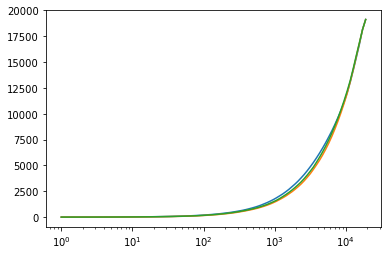

In [54]:
num_points = 100
log_spaced_values = np.logspace(0, np.log10(19000), num=num_points)
k_values = np.round(log_spaced_values).astype(int)
k_values = np.unique(k_values)
print(k_values)
common_genes = []
for k in k_values:
    print(k)
    dmd_data_2015_e, _ = filterGeneSet(tpm_2015, tpm_2018, k=k, criteria=selectionCriteria[0])
    dmd_data_2015_m, _ = filterGeneSet(tpm_2015, tpm_2018, k=k, criteria=selectionCriteria[1])
    dmd_data_2015_a, _ = filterGeneSet(tpm_2015, tpm_2018, k=k, criteria=selectionCriteria[2])
    common_genes.append([dmd_data_2015_e.shape[0], dmd_data_2015_m.shape[0], dmd_data_2015_a.shape[0]])
    
cg = np.array(common_genes)
#print(common_genes)
#print(cg)
plt.plot(k_values, cg)
plt.xscale('log')

## Scratch

In [ ]:
!head /nfs/turbo/umms-indikar/shared/projects/cell_cycle/data/RNA_pipeline_ouputs/countMatrix/counts.raw.txt

In [ ]:
!head /nfs/turbo/umms-indikar/shared/projects/myod/data/rnaseq/2018_rna/countMatrix/counts.raw.txt